## Цели:

### Первостепенные цели: 
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


### Шаги:

1. Обработать данные и провести анализ в обеих задачах.
2. Для первой задачи обучить линейную модель и дерево решений и вычислить кастомную метрику для них.
3. Для второй задачи добавить новый признак и затем создать модель с лучшим roc_auc с помощью пайплайна.

## Подготовка к обеим задачам

Обновим scikit-learn, так как многие ученики жаловались, что у ревьюера и ученика разные версии и код не работает.


In [1]:
pip install --upgrade scikit-learn -q 

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install optuna -q

In [3]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, \
                                  MinMaxScaler, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer 
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import clone

import shap

from optuna.integration import OptunaSearchCV 
from optuna import distributions

RANDOM_STATE = 42

Создание датасетов

## Задача 1

### Предобработка данных

Импортируем датасеты.

In [6]:
train_jsr = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_jsr = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

test_jsr.head(10)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


#### Работа с train_jsr

In [7]:
train_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
train_jsr.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


По типам столбцов все верно.

In [9]:
train_jsr['id'].nunique()

4000

Все id уникальны, так что можем сделать их индексами таблицы.

In [10]:
train_jsr.set_index('id', drop=True, inplace=True)
train_jsr.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


Проверим на ошибки в категориях.

In [11]:
train_jsr_cat_col = list(train_jsr.select_dtypes(['object']).columns)

for i in train_jsr_cat_col:
    print(i, train_jsr[i].unique())

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Тут отлично - ошибок нет. Видим только наны, как раз в методе инфо заметили 6 пропусков в dept и 4 в level. Это всего 10 значений (и то если не пересекаются) из 4000. Так что их лучше удалить, чем рисковать заполнить не темм и навередить модели.

Но из-за задания оставим все пропуски.

In [12]:
train_jsr.fillna(np.nan, inplace=True)
train_jsr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [13]:
train_jsr[train_jsr['dept'].isna()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
694746,NaN,junior,medium,5,no,no,4,21600,0.62
814624,NaN,junior,medium,3,no,no,4,24000,0.88
475114,NaN,junior,high,4,no,no,4,31200,0.63
497243,NaN,junior,medium,1,no,no,3,26400,0.28
168668,NaN,junior,low,3,no,no,4,18000,0.88
641150,NaN,junior,low,3,no,yes,4,12000,0.54


Супер, пропусков нет, давайте проверим на дубликаты. 

In [14]:
train_jsr.duplicated().sum()

245

Удалим полные дубликаты.

In [15]:
train_jsr.drop_duplicates(inplace=True)
train_jsr.duplicated().sum()

0

#### Работа с test_features

In [16]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [17]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Повторим все то же, что делали с train_jsr

In [18]:
test_features['id'].nunique()

2000

In [19]:
test_features.set_index('id', drop=True, inplace=True)
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [20]:
test_features_cat_col = list(test_features.select_dtypes(['object']).columns)

for i in test_features_cat_col:
    print(i, test_features[i].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


In [21]:
test_features.loc[test_features['dept'] == ' ', 'dept'] = np.nan
test_features.loc[test_features['workload'] == ' ', 'workload'] = np.nan

In [22]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1997 non-null   object
 1   level                  1999 non-null   object
 2   workload               1999 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [23]:
for i in test_features_cat_col:
    print(i, test_features[i].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' nan]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


#### Работа с test_jsr

In [24]:
test_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [25]:
test_jsr.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Тут мы можем только превратить id в индекс, других проблем быть не неможет.

In [26]:
test_jsr['id'].nunique()

2000

In [27]:
test_jsr.set_index('id', drop=True, inplace=True)
test_jsr.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


С базовой предобработкой покончено, но возможно приедтся удалить какие небудь гигантсие выбросы на этапе с анализом.

#### Вывод по этапу:

Мы импортировали таблицы, перенесли id в индексы, а также избавились от пропусков.

### Анализ данных и подготовка к работе с моделью

Построим графики для всех данных из нашего основного датасета. Также глазком глянем в тренировочный датасет, но лишь на тот случай, что там окажется сильный выброс.

In [28]:
train_jsr_cat_col = list(train_jsr.select_dtypes(['object']).columns)
train_jsr_num_col = list(train_jsr.select_dtypes(['int64', 'float64']).columns)

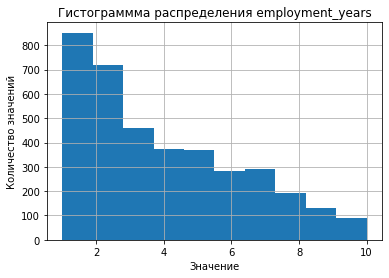

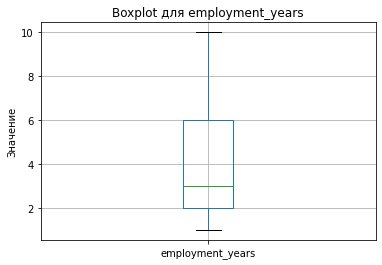

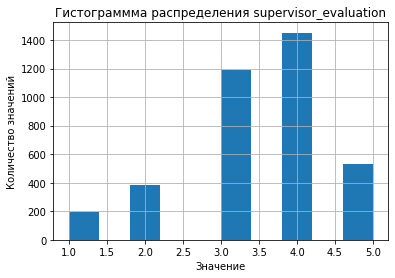

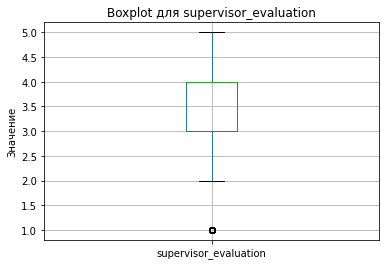

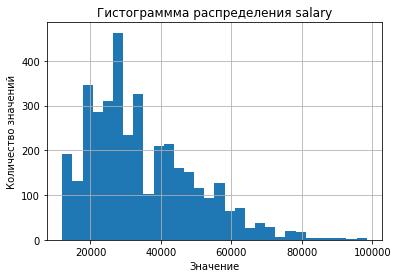

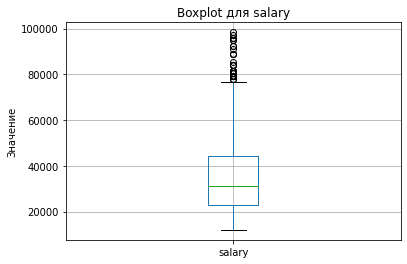

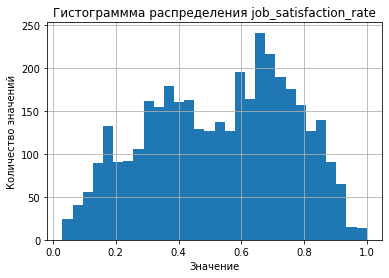

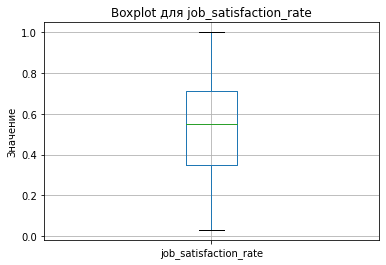

In [29]:
for i in train_jsr_num_col:
    plt.title(f'Гистограммма распределения {i}')
    if train_jsr[i].nunique() < 30:
        train_jsr[i].hist(bins=10)
    else:
        train_jsr[i].hist(bins=30)
    plt.ylabel('Количество значений')
    plt.xlabel('Значение')
    plt.show();
    
    plt.title(f'Boxplot для {i}')
    train_jsr.boxplot(column=i)
    plt.ylabel('Значение')
    plt.show();

Отличные распределения, каких и следовало ожидать, выбросов нет.

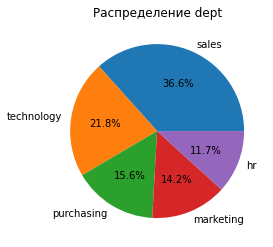

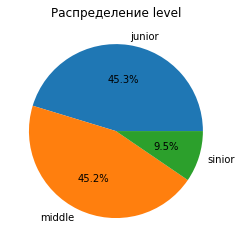

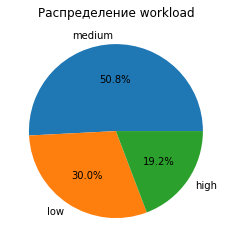

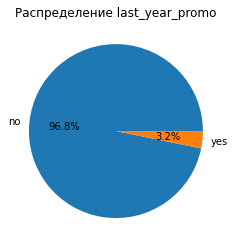

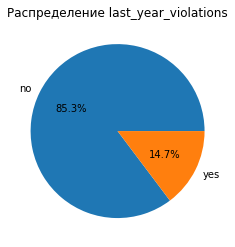

In [30]:
for i in train_jsr_cat_col:
    train_jsr_group = train_jsr.groupby(i)['job_satisfaction_rate'].count().sort_values(ascending=False)
    plt.pie(train_jsr_group, labels=train_jsr_group.index, autopct='%1.1f%%')
    plt.title(f'Распределение {i}');
    plt.show();

Мы видим, что большинство сотрудников - это джуны.  
Чуть более половины сотрудников имеют средний уровень нагрузки.   
Больше трети сотрудников продажники.   
А также 10% сотредников получило повышение в прошлом году и 14% нарушило трудовой договор.

Пока не понятно, как воспользоваться этой информацией в данном исследовании, но таблица корееляций должна будет обьяснить это.

#### А пока быстренько глянем на числовые распределения в тестовой выборке.

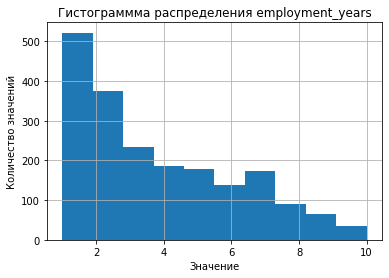

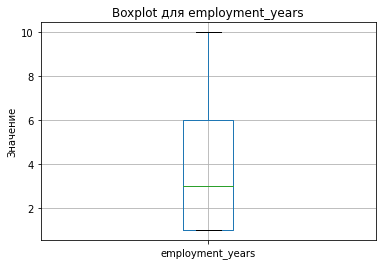

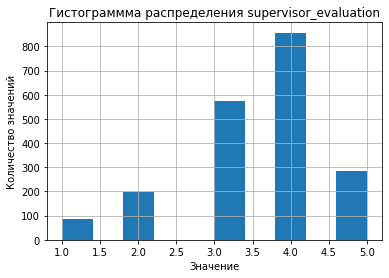

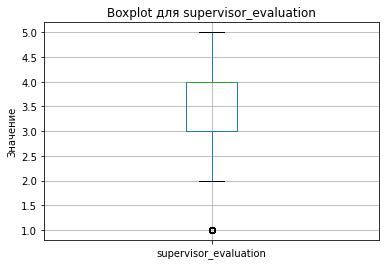

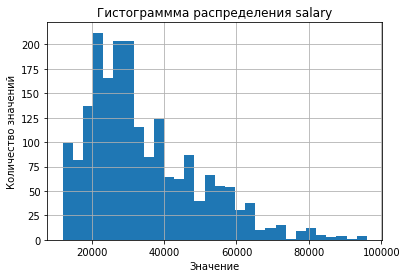

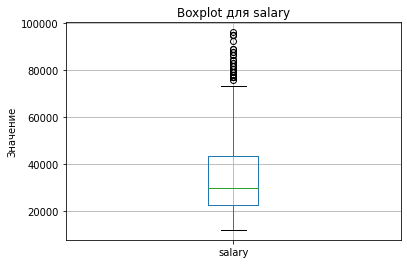

In [31]:
test_features_num_col = list(test_features.select_dtypes(['int64', 'float64']).columns)
for i in test_features_num_col:
    plt.title(f'Гистограммма распределения {i}')
    if test_features[i].nunique() < 30:
        test_features[i].hist(bins=10)
    else:
        test_features[i].hist(bins=30)
    plt.ylabel('Количество значений')
    plt.xlabel('Значение')
    plt.show();
    
    plt.title(f'Boxplot для {i}')
    test_features.boxplot(column=i)
    plt.ylabel('Значение')
    plt.show();

Отлично, в данных явных выбросов нет, остальное трогать не будем, ради честности эксперимента.

#### Строим таблицу корреляций

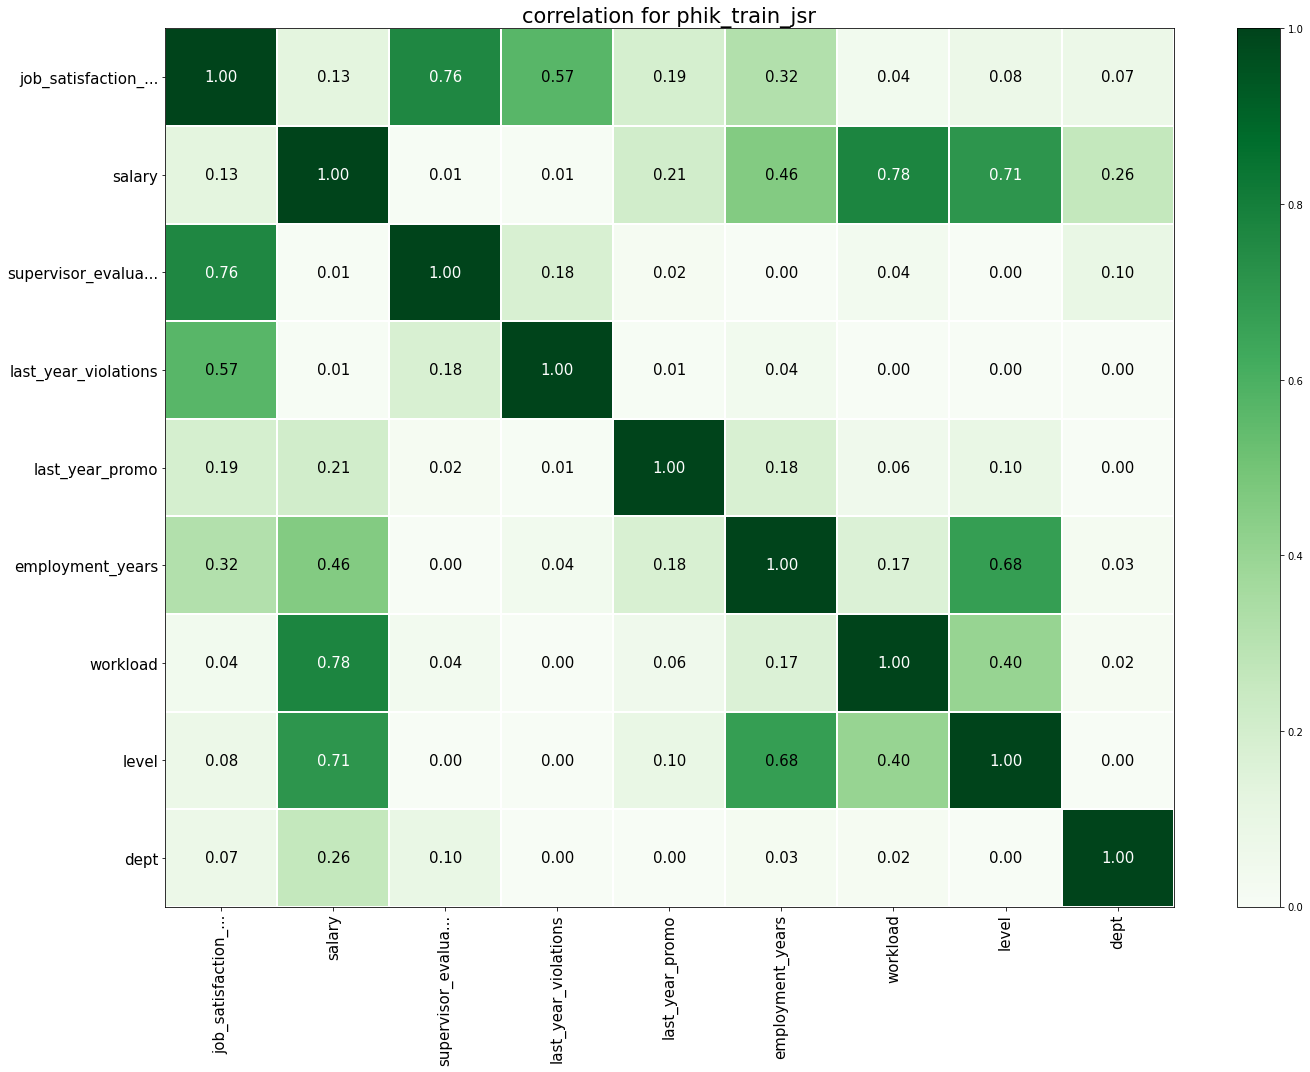

In [32]:
interval_cols = train_jsr_num_col
phik_train_jsr = train_jsr.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_train_jsr.values,
    x_labels=phik_train_jsr.columns,
    y_labels=phik_train_jsr.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation for phik_train_jsr',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Также если счиать порогом слишкой высокой корреляции 0.7, то придется удалить salary, так как он очень сильно коррелирует с workload и level. Но мы это сделаем только для линейной модели, так как мультиколлинеарность не сильно влияет на деревья.

Создадим кастомный скорер.

In [33]:
def smape(y_actual, y_pred):
    n = y_pred.shape[0]
    value = (2 * np.absolute(y_pred-y_actual) / (np.absolute(y_pred) + np.absolute(y_actual))).sum()
    result = value * 100 / n
    return result

In [34]:
smape_scorer = make_scorer(smape, greater_is_better = False)

#### Вывод по этапу:

1. Мы проанализировали данные: 
    * большинство сотрудников - это джуны.
    * Чуть более половины сотрудников имеют средний уровень нагрузки.
    * Больше трети сотрудников продажники.
    * 10% сотредников получило повышение в прошлом году и 14% нарушило трудовой договор.
2. Построили матрицу корреляций и избавились от метрик supervisor_evaluation, salary.
3. Создали метриуц для оценки моделей

### Создание моделей

Тестовая выборка у нас уже выделена, так что ее выделять не будем. Так что насчнем с пайплайна по обработке и нормализации значений:

In [35]:
X_train_1 = train_jsr.drop('job_satisfaction_rate', axis=1)
y_train_1 = train_jsr['job_satisfaction_rate']

Создадим тестовую выборку. (склеим и разобьем обратно, что бы избавится от несуществующих id)

In [36]:
test_1 = test_features.merge(test_jsr, how='left', left_index=True, right_index=True)
X_test_1 = test_1.drop('job_satisfaction_rate', axis=1)
y_test_1 = test_1['job_satisfaction_rate']

In [37]:
y_test_1

id
485046    0.79
686555    0.72
467458    0.64
418655    0.60
789145    0.75
          ... 
393147    0.56
109582    0.14
305653    0.11
160233    0.43
771859    0.67
Name: job_satisfaction_rate, Length: 2000, dtype: float64

In [38]:
X_train_1_cat_col = list(X_train_1.select_dtypes(['object']).columns)
X_train_1_num_col = list(X_train_1.select_dtypes(['int64', 'float64']).columns)

In [39]:
X_train_1_cat_col.remove('level')
X_train_1_cat_col.remove('workload')
X_train_1_ord_col = ['level', 'workload']
X_train_1_cat_col

['dept', 'last_year_promo', 'last_year_violations']

In [40]:
X_train_1['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

#### Создадим пайплайн для дерева.

In [41]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        # В наших данных пропусков нет, но это может пригодится в дальнейшем для других данных.
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='error'))
    ]
 )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, X_train_1_cat_col),
        ('ord', ord_pipe, X_train_1_ord_col),
        ('num', MinMaxScaler(), X_train_1_num_col)
    ], 
    remainder='passthrough'
)

In [42]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_1_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_grid_1_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'models__min_samples_leaf': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_1_tree = RandomizedSearchCV(
    pipe_final_1_tree, 
    param_distributions=param_grid_1_tree, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_iter=50,
    n_jobs=-1
)

randomized_search_1_tree.fit(X_train_1, y_train_1)

print('Лучшая модель и её параметры:\n\n', randomized_search_1_tree.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_1_tree.best_score_ * -1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

Метрика выше требуемого, но давайте попробуем ее на тестовых данных.

In [43]:
best_tree_pipe_1 = randomized_search_1_tree.fit(X_train_1, y_train_1)
y_pred_1_tree = best_tree_pipe_1.predict(X_test_1)

In [44]:
smape(y_test_1, y_pred_1_tree)

13.515880385268872

Результат очень хороший и подходит под наши критерии, теперь рассмотрим как сработает линейная модель.

#### Создаем пайплайн для линейных моделей.

Теперь избавимся от мультиколлинеарности.

In [45]:
train_jsr.drop(['salary'], axis=1, inplace=True)
train_jsr.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,job_satisfaction_rate
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,0.58
653870,hr,junior,high,2,no,no,5,0.76
184592,sales,junior,low,1,no,no,2,0.11
171431,technology,junior,low,4,no,no,2,0.37
693419,hr,junior,medium,1,no,no,3,0.20


In [46]:
train_jsr.duplicated().sum() # появились дубликаты, избавимся от них.
train_jsr.drop_duplicates(inplace=True)
train_jsr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3526 entries, 155278 to 338347
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3520 non-null   object 
 1   level                  3522 non-null   object 
 2   workload               3526 non-null   object 
 3   employment_years       3526 non-null   int64  
 4   last_year_promo        3526 non-null   object 
 5   last_year_violations   3526 non-null   object 
 6   supervisor_evaluation  3526 non-null   int64  
 7   job_satisfaction_rate  3526 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 247.9+ KB


In [47]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_1_linear = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_grid_1_linear = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

grid_search_1_linear = GridSearchCV(
    pipe_final_1_linear, 
    param_grid=param_grid_1_linear, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)

grid_search_1_linear.fit(X_train_1, y_train_1)

print('Лучшая модель и её параметры:\n\n', grid_search_1_linear.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_1_linear.best_score_ * -1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

Метрика намного хуже, так что даже не будем пытаться подставлять ее в тестовые данные.

#### Вывод по этапу:
    
Дерево регрессии справляется, лучше чем линейная регрессия. И дает нам метрику 13.52 на тестовой выборке. Все критерии выполняются.

### Выводы по первой задаче:

1. Целевая метрика сильно коррелирует с оценкой от начальства. 
2. Мы построили две модели, и дерево справляется намного лучше, чем линейная регрессия.
3. Целевая метрика SMAPE лучше требуемой - 13.52.

## Задача 2

### Предобработка данных

Импортируем датасеты.

In [48]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
# test_features общая для обеих задач
test_quit = pd.read_csv('/datasets/test_target_quit.csv')

test_quit.head(10)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

#### Работа с trian_quit

In [49]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [50]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [51]:
train_quit['id'].nunique()

4000

In [52]:
train_quit_cat_col = list(train_quit.select_dtypes(['object']).columns)

for i in train_quit_cat_col:
    print(i, train_quit[i].unique())

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level ['middle' 'junior' 'sinior']
workload ['high' 'medium' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']
quit ['no' 'yes']


In [53]:
train_quit.duplicated().sum()
train_quit.drop_duplicates(inplace=True)
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 343.8+ KB


В данных ошибок не видно, и на дубликаты проверять не будем, так как уже поняли, что много одинаковых работников. Проверку на выббросы проведем вместе с анализом данных.

#### Работа с test_quit

In [54]:
test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [55]:
test_quit['id'].nunique()

2000

In [56]:
test_quit_cat_col = list(test_quit.select_dtypes(['object']).columns)

for i in test_quit_cat_col:
    print(i, test_quit[i].unique())

quit ['yes' 'no']


Тут все тоже отлично перейдем к следующему этапу.

#### Смена индекса

Установим этим двум датасетам id в качестве индекса.

In [57]:
train_quit.set_index('id', drop=True, inplace=True)
test_quit.set_index('id', drop=True, inplace=True)

#### Вывод по этапу:

С данными все отлично. И вдобавок мы заменили индексы, на более удобные id.

### Анализ данных и подготовка к работе с моделью

Построим графики для всех данных из нашего основного датасета. И сравним оставшихся и ушедших работников. (Слева - оставшиеся, справа ушедшие)

In [58]:
train_quit_cat_col = list(train_quit.select_dtypes(['object']).columns)
train_quit_cat_col.remove('quit')
train_quit_num_col = list(train_quit.select_dtypes(['int64', 'float64']).columns)

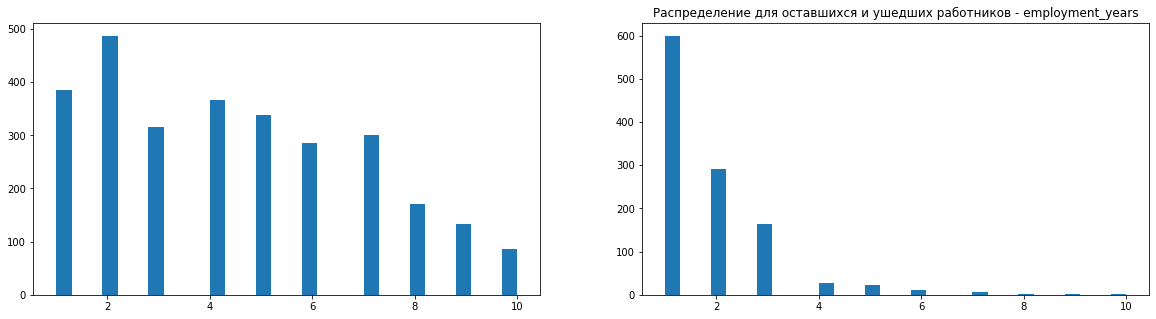

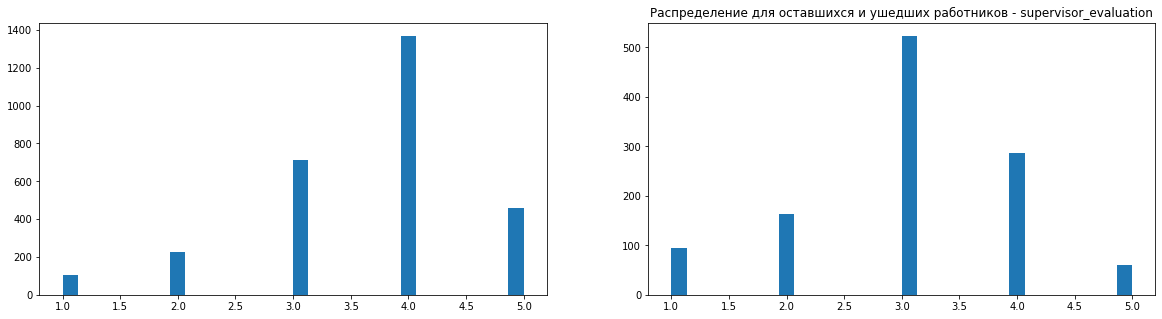

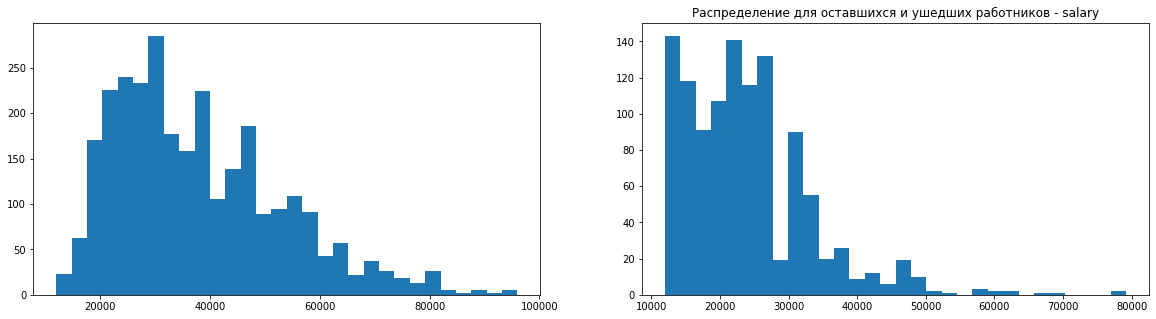

In [59]:

for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    
    plt.title(f'Распределение для оставшихся и ушедших работников - {train_quit_num_col[i]}')
    ax[0].hist(train_quit[train_quit['quit'] == 'no'][train_quit_num_col[i]], bins=30)
    ax[1].hist(train_quit[train_quit['quit'] == 'yes'][train_quit_num_col[i]], bins=30)
    plt.show()

    

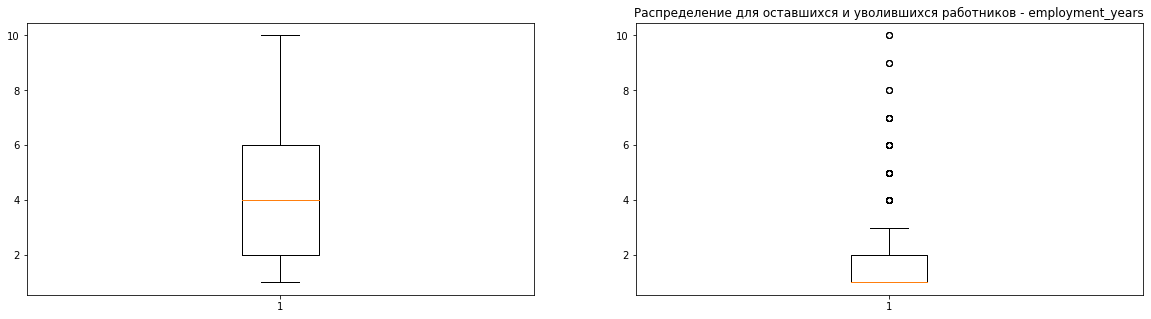

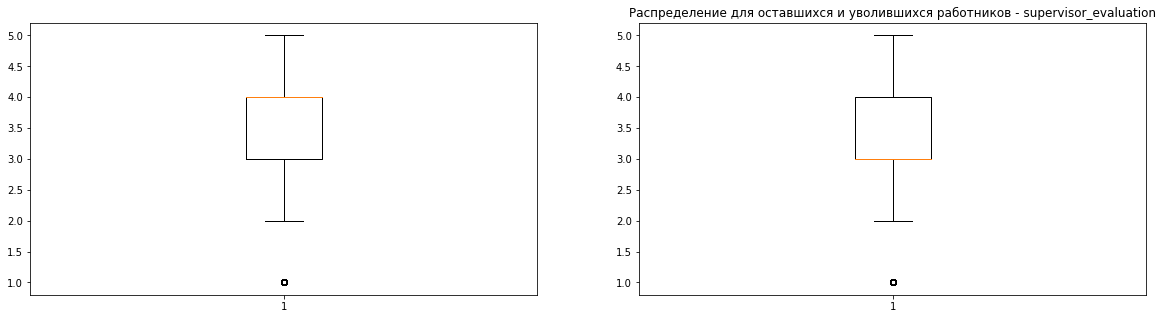

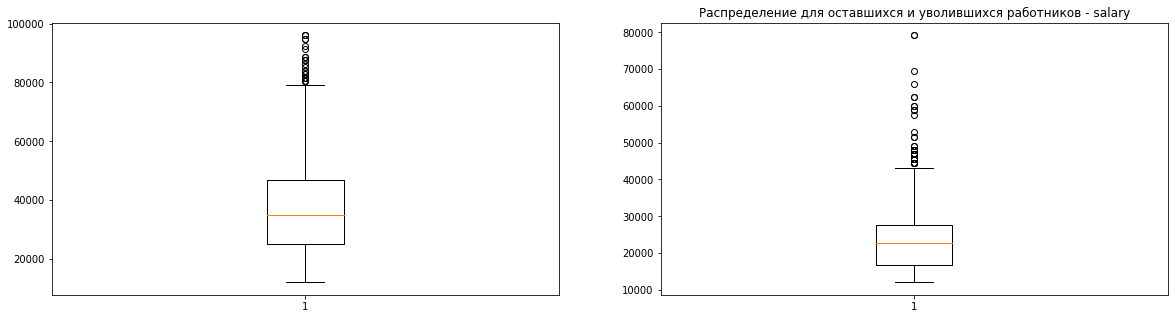

In [60]:

for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    
    plt.title(f'Распределение для оставшихся и уволившихся работников - {train_quit_num_col[i]}')
    ax[0].boxplot(train_quit[train_quit['quit'] == 'no'][train_quit_num_col[i]])
    ax[1].boxplot(train_quit[train_quit['quit'] == 'yes'][train_quit_num_col[i]])
    plt.show()

    

In [61]:
print(train_quit[train_quit['quit'] == 'yes']['salary'].median())
print(train_quit[train_quit['quit'] == 'no']['salary'].median())

22800.0
34800.0


Мы видим много интересых особенностей.

У оставшихся работников время службы постепенно убывает с увеличением лет. Но до 10 лет дошло почти 100 сотрудников. В то время как большинство ушедших сотрудников проработало менее 4 лет.

Также середина распределения оценки от руководителя у оставшихся сотрудников выше. 4 против 3. 

Зарплата у ушедших сотрудников тоже меньше. Медиана, например, отличется на 12,000.

Теперь посмотрим на категриальные признаки.

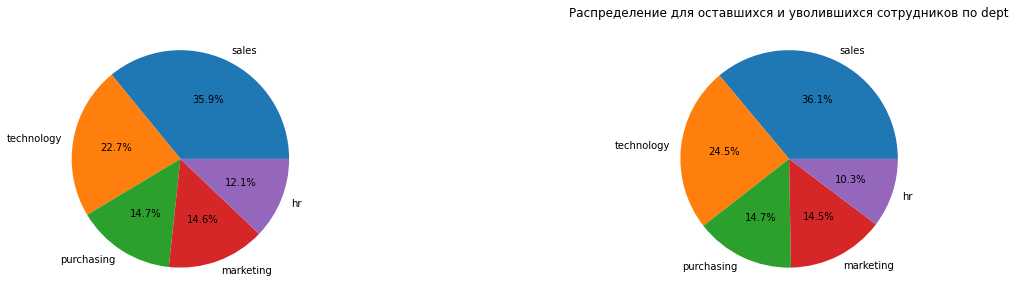

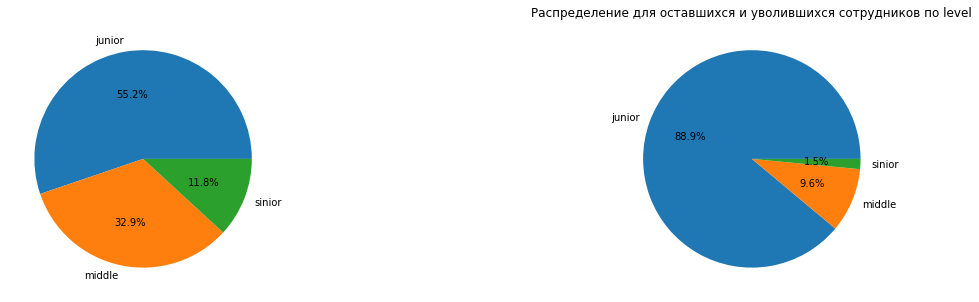

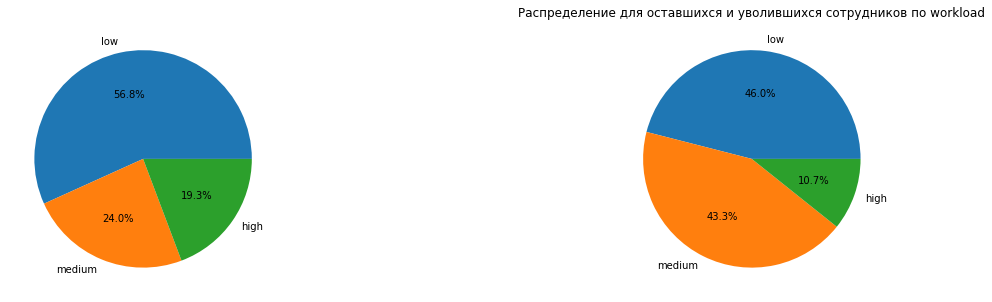

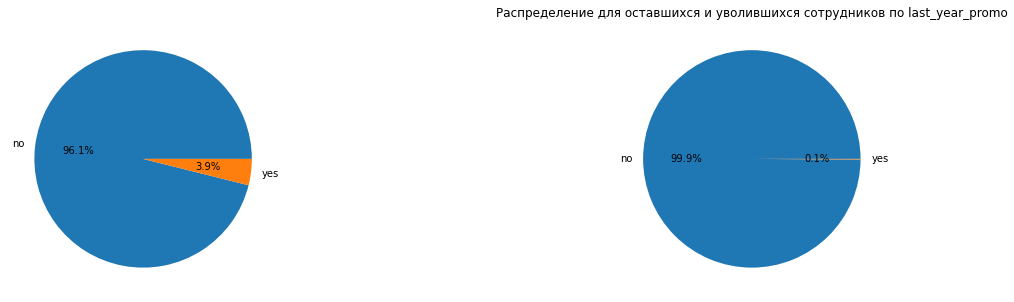

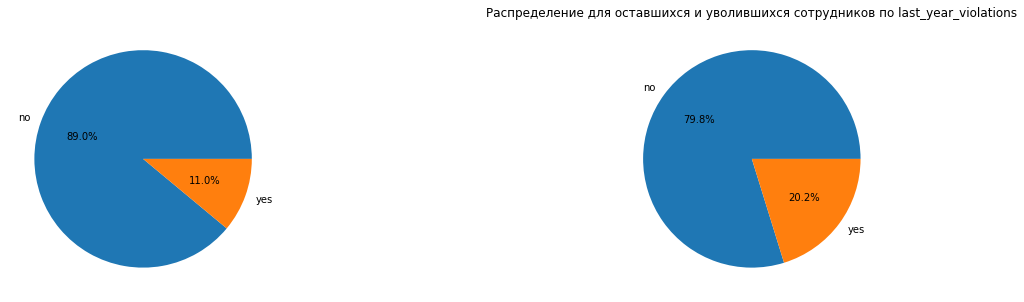

In [62]:
for i in train_quit_cat_col:
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    train_quit_group_yes = train_quit[train_quit['quit'] == 'yes'].groupby(i)['salary'].count().sort_values(ascending=False)
    train_quit_group_no = train_quit[train_quit['quit'] == 'no'].groupby(i)['salary'].count().sort_values(ascending=False)
    
    labels = train_quit_group_yes.index
    colours = dict(zip(labels, plt.cm.tab10.colors[:len(labels)]))
    ax[0].pie(train_quit_group_no, labels=labels, autopct='%1.1f%%', colors=[colours[key] for key in labels])
    ax[1].pie(train_quit_group_yes, labels=labels, autopct='%1.1f%%', colors=[colours[key] for key in labels])
    plt.title(f'Распределение для оставшихся и уволившихся сотрудников по {i}');
    plt.show()


1. По отделам разницы почти нет, то есть сотрудники одинаково уходят из всех отделов. 
2. Почти 90% ушедших сотрудников джуны. 
3. 46% уволившихся сотрудников имели низкий уровень занятости, и 56% оставшихся тоже низкий. Получается у уволившихся сотрудников уровень занятости выше низкого выше чем у оставшихся сотрудников.
4. Почти все кто уволились не получили повышения.
5. 20% уволившихся сотрудников совершали нарушения в прошлом году. И только 11% оставшихся сотрудников тоже нарушили правила.

#### портрет «уволившегося сотрудника»

Очень вероятно, что это джун, которого не повышали в прошлом году и который совершил нарушение. Также вероятно, что его зарплата около 23 тыс, он проработал менее 4 лет и имел оценку 3 от руководителя.

#### проверим связаны ли quit и job_satisfaction_rate

In [63]:
df = test_features.merge(test_jsr, how='left', left_index=True, right_index=True)
df = df.merge(test_quit, how='left', left_index=True, right_index=True)
df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


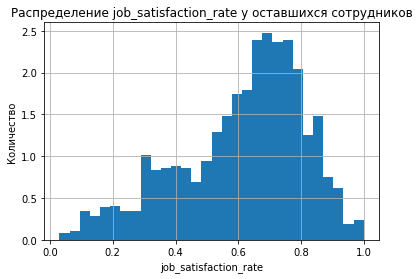

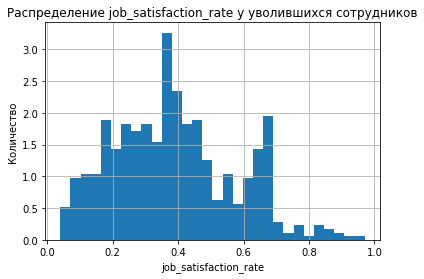

In [64]:
df[df['quit'] == 'no']['job_satisfaction_rate'].hist(bins=30, density=True)
plt.title('Распределение job_satisfaction_rate у оставшихся сотрудников')
plt.ylabel('Количество')
plt.xlabel('job_satisfaction_rate')
plt.show();

df[df['quit'] == 'yes']['job_satisfaction_rate'].hist(bins=30, density=True)
plt.title('Распределение job_satisfaction_rate у уволившихся сотрудников')
plt.ylabel('Количество')
plt.xlabel('job_satisfaction_rate')
plt.show();

Мы видим, что у уволившихся сотрудников распределение и правда смещено влево относительно оставшихся сотрудников. Значит эти две метрики взаимосвязаны.

#### Вывод по этапу:

1. По отделам разницы почти нет, то есть сотрудники одинаково уходят из всех отделов. 
2. Почти 90% ушедших сотрудников джуны. 
3. Получается у уволившихся сотрудников уровень занятости выше низкого выше чем у оставшихся сотрудников.
4. Почти все кто уволились не получили повышения.
5. 20% уволившихся сотрудников совершали нарушения в прошлом году. И только 11% оставшихся сотрудников тоже нарушили правила.
6. У оставшихся работников время службы постепенно убывает с увеличением лет. Но до 10 лет дошло почти 100 сотрудников. В то время как большинство ушедших сотрудников проработало менее 4 лет.
7. Середина распределения оценки от руководителя у оставшихся сотрудников выше. 4 против 3. 
8. Зарплата у ушедших сотрудников тоже меньше. Медиана, например, отличется на 12,000.
9. job_satisfaction_rate связан с увольнением сотркдника.

#### Добавление нового входного признака

Добавим признак job_satisfaction_rate в таблицу train_quit с помощью модели из первого задания. (Но помним, что пока у нас модель такая себе, так что это повлияет на результаты второго задания)

In [65]:
train_quit['job_satisfaction_rate'] = best_tree_pipe_1.predict(train_quit)
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.607778
814010,sales,junior,medium,2,no,no,4,27600,no,0.851538
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.337500
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


### Подготовка данных

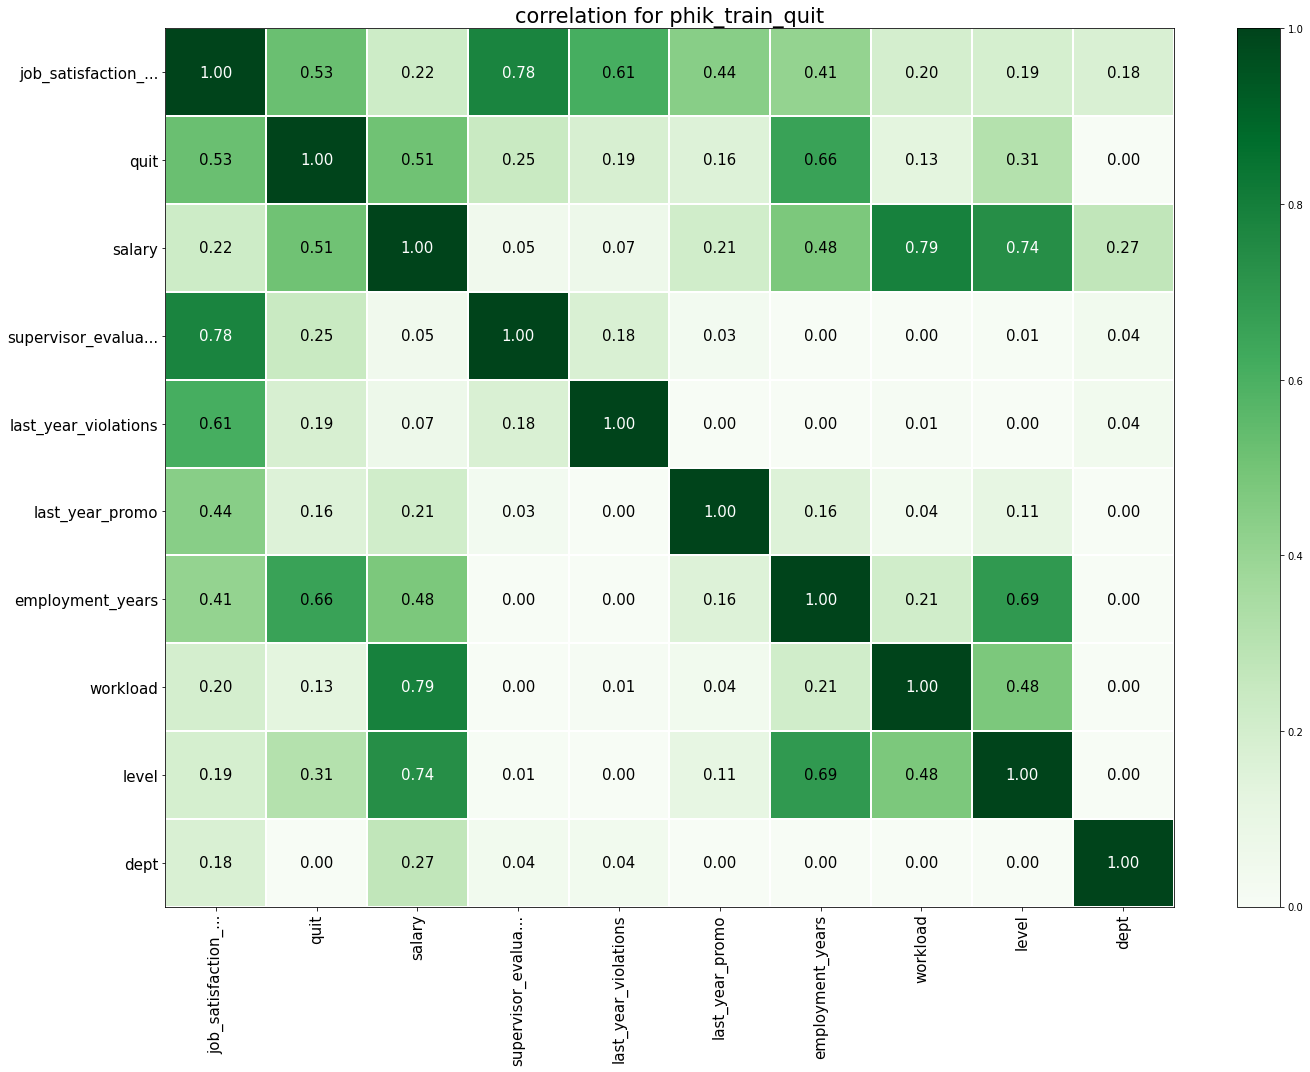

In [66]:
interval_cols = list(train_quit.select_dtypes(['int64', 'float64']).columns)
phik_train_quit = train_quit.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_train_quit.values,
    x_labels=phik_train_quit.columns,
    y_labels=phik_train_quit.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation for phik_train_quit',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Удаляем supervisor_evaluation из-за мульти коллинеарности. Salary трогать не будем, так как она сильно коррелирует с целевой quit.

In [67]:
X_train_2 = train_quit.drop('quit', axis=1)
y_train_2 = train_quit['quit']

X_test_2 = df.drop('quit', axis=1)
y_test_2 = df['quit']

le = LabelEncoder()
y_train_2 = le.fit_transform(y_train_2)
y_test_2 = le.transform(y_test_2)

In [68]:
y_train_2

array([0, 0, 0, ..., 1, 0, 1])

### Строим модель

In [69]:
X_train_2_cat_col = list(X_train_2.select_dtypes(['object']).columns)
X_train_2_num_col = list(X_train_2.select_dtypes(['int64', 'float64']).columns)
X_train_2_ord_col = ['level', 'workload']
X_train_2_cat_col = ['last_year_promo', 'last_year_violations', 'dept']

In [70]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        # В наших данных пропусков нет, но это может пригодится в дальнейшем для других данных.
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='error'))
    ]
 )


ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, X_train_2_cat_col),
        ('ord', ord_pipe, X_train_2_ord_col),
        ('num', MinMaxScaler(), X_train_2_num_col)
    ], 
    remainder='passthrough'
)

In [71]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2= Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_tree_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 20),
        'models__min_samples_leaf': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_tree_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_tree_2, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=30,
    random_state=RANDOM_STATE
)

randomized_search_tree_2.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', randomized_search_tree_2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_tree_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_b

roc_auc получился 0.927 - отличный результат. Посмотрим на тестовую выборку.

In [72]:
best_pipe_tree_2 = randomized_search_tree_2.fit(X_train_2, y_train_2)
y_pred_tree_2 = best_pipe_tree_2.predict_proba(X_test_2)[:,1]

In [73]:
roc_auc_score(y_test_2, y_pred_tree_2)

0.9160956113317134

Отличный результат, но попробуем линейные модели убрав мультиколлинеарность.

In [74]:
train_quit_nt = train_quit.copy(deep=True)

train_quit_nt.drop(['salary', 'supervisor_evaluation'], axis=1)

train_quit_nt.drop_duplicates(inplace=True)

X_train_2_not_tree = train_quit_nt.drop('quit', axis=1)
y_train_2_not_tree = train_quit_nt['quit']

X_test_2_not_tree = df.drop('quit', axis=1)
y_test_2_not_tree = df['quit']

le = LabelEncoder()
y_train_2_not_tree = le.fit_transform(y_train_2_not_tree)
y_test_2_not_tree = le.transform(y_test_2_not_tree)

In [75]:
X_train_2_nt_cat_col = list(X_train_2_not_tree.select_dtypes(['object']).columns)
X_train_2_nt_num_col = list(X_train_2_not_tree.select_dtypes(['int64', 'float64']).columns)
X_train_2_nt_ord_col = ['level', 'workload']
X_train_2_nt_cat_col = ['last_year_promo', 'last_year_violations', 'dept']

In [76]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='error'))
    ]
 )


ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


data_preprocessor_2_nt = ColumnTransformer(
    [
        ('ohe', ohe_pipe, X_train_2_nt_cat_col),
        ('ord', ord_pipe, X_train_2_nt_ord_col),
        ('num', MinMaxScaler(), X_train_2_nt_num_col)
    ], 
    remainder='passthrough'
)

In [77]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2= Pipeline(
    [
        ('preprocessor', data_preprocessor_2_nt),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid_not_tree_2 = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_not_tree_2 = GridSearchCV(
    pipe_final_2, 
    param_grid_not_tree_2, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

randomized_search_not_tree_2.fit(X_train_2_not_tree, y_train_2_not_tree)

print('Лучшая модель и её параметры:\n\n', randomized_search_not_tree_2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_not_tree_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_b

In [78]:
best_pipe_not_tree_2 = randomized_search_not_tree_2.fit(X_train_2_not_tree, y_train_2_not_tree)
y_pred_not_tree_2 = best_pipe_not_tree_2.predict_proba(X_test_2_not_tree)[:,1]

In [79]:
roc_auc_score(y_test_2_not_tree, y_pred_not_tree_2)

0.9072186333195045

Линейная модель справляется хуже дерева. Но нашу цель мы все равно выполнили.

Roc-auc получился 0.916 - отличный результат, который подходит под требуемые критерии. Можем переходить к выводам.

### Вывод по второму заданию:

1. По отделам разницы почти нет, то есть сотрудники одинаково уходят из всех отделов. 
2. Почти 90% ушедших сотрудников джуны. 
3. Получается у уволившихся сотрудников уровень занятости выше низкого выше чем у оставшихся сотрудников.
4. Почти все кто уволились не получили повышения.
5. 20% уволившихся сотрудников совершали нарушения в прошлом году. И только 11% оставшихся сотрудников тоже нарушили правила.
6. У оставшихся работников время службы постепенно убывает с увеличением лет. Но до 10 лет дошло почти 100 сотрудников. В то время как большинство ушедших сотрудников проработало менее 4 лет.
7. Середина распределения оценки от руководителя у оставшихся сотрудников выше. 4 против 3. 
8. Зарплата у ушедших сотрудников тоже меньше. Медиана, например, отличется на 12,000.
9. job_satisfaction_rate связан с увольнением сотркдника.
10. Лучшая модель для предсказывания увольнения - это дерево.
11. Мы получули roc-score  0.916 на тестовой выборке, что является отличным результатом.

## Общий вывод:

1. Уровень удовлетворённости сильно коррелирует с оценкой от начальства.
2. В первой задаче мы построили две модели, и дерево справляется намного лучше, чем линейная регрессия.
3. Целевая метрика SMAPE лучше требуемой - 13.52.
4. По отделам разницы почти нет, то есть сотрудники одинаково уходят из всех отделов. 
5. Почти 90% ушедших сотрудников джуны. 
6. Получается у уволившихся сотрудников уровень занятости выше низкого выше чем у оставшихся сотрудников.
7. Почти все кто уволились не получили повышения.
8. 20% уволившихся сотрудников совершали нарушения в прошлом году. И только 11% оставшихся сотрудников тоже нарушили правила.
9. У оставшихся работников время службы постепенно убывает с увеличением лет. Но до 10 лет дошло почти 100 сотрудников. В то время как большинство ушедших сотрудников проработало менее 4 лет.
10. Середина распределения оценки от руководителя у оставшихся сотрудников выше. 4 против 3. 
11. Зарплата у ушедших сотрудников тоже меньше. Медиана, например, отличется на 12,000.
12. job_satisfaction_rate связан с увольнением сотркдника.
13. Лучшая модель для предсказывания увольнения - это дерево.
14. Мы получули roc-score  0.916 на тестовой выборке, что является отличным результатом.

## Рекомендации для бизнеса

Теперь с помощью этих моделей бизнем может предсказывать удовлетворенность сотрудникка работой, а также вероятность уйдет ли он из компании. Что сможет сократить риски и убытки компании.

Три самых важных фактора влияющих на уход сотрудника - это уго удовлетворенность, зарплата, и стаж работы в компании.